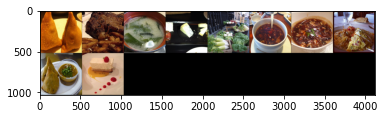

Getting ready to train


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import csv
import cnn



# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 10
batch_size = 10
learning_rate = 0.001
    
# 512x512 color images in 11 classes
train_dataset = cnn.CustomImageDataset("annotations_file_training.csv", "All_training", transform=torchvision.transforms.Resize((512,512)))

validation_dataset = cnn.CustomImageDataset("annotations_file_validation.csv", "All_validation", transform=torchvision.transforms.Resize((512,512)))

test_dataset = cnn.CustomImageDataset("annotations_file_evaluation.csv", "All_evaluation", transform=torchvision.transforms.Resize((512,512)))
                                            
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
                                          
classes = ('bread', 'dairy' 'products', 'dessert', 'eggs', 'fried food', 'meat', 'noodles-pasta', 'rice', 'seafood', 'soup', 'vegetables-fruits')


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# Let's train that bitch
print("Getting ready to train")
model = cnn.ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

steps_train = len(train_loader)
steps_val = len(validation_loader)
train_loss = []
validation_loss = []

for epoch in range(num_epochs):
    
    mean_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images.float())
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        mean_loss = mean_loss + loss.item()
        print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{steps_train}], Loss: {loss.item():.4f}', end='\r')
        if (i + 1) == len(train_loader):
            mean_loss = mean_loss/steps_train
            train_loss.append(mean_loss)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{steps_train}], Train Loss: {train_loss[epoch]:.4f}', end='\r')
            
    mean_loss = 0
    for i, (images, labels) in enumerate(validation_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images.float())
        loss = criterion(outputs, labels)

        mean_loss = mean_loss + loss.item()
        print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{steps_train}/{steps_train}], Train Loss: {train_loss[epoch]:.4f}, Step [{i + 1}/{steps_val}], Loss: {loss.item():.4f}', end='\r')
        if (i + 1) == len(validation_loader):
            mean_loss = mean_loss/steps_val
            validation_loss.append(mean_loss)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{steps_train}/{steps_train}], Train Loss: {train_loss[epoch]:.4f}, Step [{i + 1}/{steps_val}], Validation Loss: {validation_loss[epoch]:.4f}')

            
# loss plots
os.mkdir("./cnn_ep{}_bs{}_lr{}".format(num_epochs, batch_size, learning_rate))
plt.figure(figsize=(10, 7))
plt.title("ep{} bs{} lr{}".format(num_epochs, batch_size, learning_rate))
plt.plot(train_loss, color='orange', linestyle='-', label='train loss')
plt.plot(validation_loss, color='red', linestyle='-', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("./cnn_ep{}_bs{}_lr{}/loss_ep{}_bs{}_lr{}.png".format(num_epochs, batch_size, learning_rate, num_epochs, batch_size, learning_rate))
plt.show()            

print('Finished Training')
PATH = "./cnn_ep{}_bs{}_lr{}/cnn_ep{}_bs{}_lr{}.pth".format(num_epochs, batch_size, learning_rate, num_epochs, batch_size, learning_rate)
torch.save(model.state_dict(), PATH)

header = ['train loss', 'validation loss']
with open("./cnn_ep{}_bs{}_lr{}/cnn_ep{}_bs{}_lr{}.csv".format(num_epochs, batch_size, learning_rate, num_epochs, batch_size, learning_rate), 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    for i in range(num_epochs):
        writer.writerow([train_loss[i], validation_loss[i]])

In [ ]:
# Load saved model
# Only run this if you want to thest a model other than the one just trained
import sys
import os
sys.path.insert(0, os.path.join(os.path.dirname(sys.argv[0]), '..'))
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cnn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classes = ('bread', 'dairy' 'products', 'dessert', 'eggs', 'fried food', 'meat', 'noodles-pasta', 'rice', 'seafood', 'soup', 'vegetables-fruits')

test_dataset = cnn.CustomImageDataset("annotations_file_evaluation.csv", "All_evaluation", transform=torchvision.transforms.Resize((512,512)))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)    

model = cnn.ConvNet().to(device)
model.load_state_dict(torch.load('cnn_ep20_bs8_lr0,001.pth'))
print('Done')

In [ ]:
# Test the model
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(11)]
    n_class_samples = [0 for i in range(11)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images.float())
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(labels.size(0)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(11):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

In [ ]:
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    output = model(images.float(), feature_conv=True)
    print(output.size())
    print(model.fc2.weight.size())
    cam = cnn.returnCAM(output, model.fc1.weight, model.fc2.weight, model.fc3.weight, 0)
    print(cam)
    break